# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [0]:
! pip install torch torchvision torchsummary sklearn

## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [0]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

### Data preprocessing

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
grayscale_images = []
colorscale_images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    if len(current_img_vector.shape)==2: # If shape is (128, 128) (no color channels)
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        grayscale_images+=[img_num]
    else:
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        colorscale_images+=[img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

#merging_method : 
# 0 : Convert  a colored image to grey image
# 1 : Complete a grey    image with zeros   to a have colored image
# 2 : Complete a grey    image with himself to a have colored image


class imageDataset(Dataset):
    def __init__(self, data_basenames, merging_method = 2, channels = 3, height = 128, width = 128, transforms = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
    #    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                train=True):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)
        self.merging_method = merging_method
        self.train = train
        
    def __getitem__(self, index):
        if self.train:
          img_path = "train/images/im" + self.data[index] + ".jpg"
        else:
          img_path = "to_test/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if(self.merging_method == 0 ):
            
            if img.shape[0] == 3:
              img = img[0] + img[1] + img[2]
              img /= 3
              img = img.reshape((1, 128, 128))
              
        elif(self.merging_method == 1):
          
            if img.shape[0] == 1:  # change graysclae images to RGB
                zeros_torser = torch.zeros([1, 128, 128])
                img = torch.cat((img,zeros_torser, zeros_torser),0)
                
        elif(self.merging_method == 2):  
            if img.shape[0] == 1:  # change graysclae images to RGB
                img = torch.cat((img,img, img),0)
        
            
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    


In [0]:
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 512

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
merge_method = 2

def build_augmented_dataset(images_basenames):
  train_dataset_orig = imageDataset(images_basenames[:index_cut], merging_method = merge_method)
  train_dataset_augmentation = imageDataset(images_basenames[:index_cut],
                                         merging_method = merge_method,
                                         transforms = transforms.Compose([
                                             transforms.RandomRotation(40),
                                             transforms.ToTensor(),
                                         ])
                                        )
  train_dataset_augmentation2 = imageDataset(images_basenames[:index_cut],
                                         merging_method = merge_method,
                                         transforms = transforms.Compose([
                                             transforms.RandomRotation(20),
                                             transforms.ToTensor(),
                                         ])
                                        )


  train_dataset_augmentation3 = imageDataset(images_basenames[:index_cut],
                                         merging_method = merge_method,
                                         transforms = transforms.Compose([
                                             transforms.RandomCrop([128, 128]),
                                             transforms.ToTensor(),
                                         ])
                                        )
  
  train_dataset = torch.utils.data.ConcatDataset([train_dataset_orig,
                                                  train_dataset_augmentation,
                                                 train_dataset_augmentation2,
                                                 train_dataset_augmentation3])
  return train_dataset

train_dataset = build_augmented_dataset(images[:index_cut])
  
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = imageDataset(images[index_cut:], merging_method = merge_method)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

tensor([[[0.5882, 0.5765, 0.5961,  ..., 0.4941, 0.5412, 0.5333],
         [0.5882, 0.5569, 0.5412,  ..., 0.4980, 0.5333, 0.5490],
         [0.5569, 0.5686, 0.5529,  ..., 0.4706, 0.4667, 0.5020],
         ...,
         [0.5647, 0.5843, 0.6039,  ..., 0.5686, 0.5333, 0.5922],
         [0.5686, 0.5882, 0.6118,  ..., 0.5843, 0.5961, 0.5843],
         [0.5765, 0.5961, 0.5922,  ..., 0.5843, 0.5569, 0.5647]],

        [[0.6039, 0.5922, 0.6118,  ..., 0.4980, 0.5451, 0.5373],
         [0.6039, 0.5725, 0.5569,  ..., 0.5020, 0.5373, 0.5529],
         [0.5804, 0.5843, 0.5686,  ..., 0.4745, 0.4706, 0.5059],
         ...,
         [0.5686, 0.5882, 0.6078,  ..., 0.5686, 0.5333, 0.5922],
         [0.5725, 0.5922, 0.6157,  ..., 0.5843, 0.5961, 0.5843],
         [0.5765, 0.6000, 0.6039,  ..., 0.5843, 0.5569, 0.5569]],

        [[0.6000, 0.5882, 0.6078,  ..., 0.4745, 0.5137, 0.5176],
         [0.6000, 0.5686, 0.5529,  ..., 0.4784, 0.5059, 0.5333],
         [0.5804, 0.5882, 0.5725,  ..., 0.4431, 0.4392, 0.

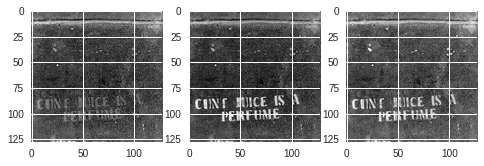

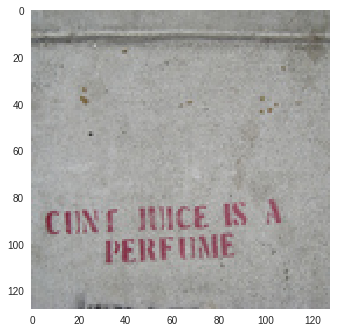

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels: []


In [0]:
# 3 channel show
data, target = next(train_loader.__iter__()) # Iteration works!

d0 = data[0]
print(d0)
t0 = target[0]

f, axs = plt.subplots(1,3)
axs[0].imshow(d0[0])
axs[1].imshow(d0[1])
axs[2].imshow(d0[2])
plt.show()

arr_ = d0.transpose(0,-1)
arr_ = np.rot90(arr_, 3)
arr_ = np.flip(arr_, axis=1)
plt.imshow(arr_)
plt.grid(None)
plt.show()
print(t0)
print("labels:", oneHotTransformer.toVocabulary(t0))

### Models

First, simple CNN architecture( exercise 3)

In [0]:
class sim_cnn_v1(nn.Module):
    def __init__(self, nclass = 14, input_channels=1):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(30*30*32, 30*32)
        self.fc2 = nn.Linear(30*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (1, 128, 128))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28800, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
       BatchNorm2d-2         [-1, 16, 126, 126]              32
              ReLU-3         [-1, 16, 126, 126]      

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14, input_channels=1):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn()

In [0]:
class deep_cnn_v2(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = deep_cnn_v2()

In [0]:
class deep_cnn_v3(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3)
        )
        self.fc1 = nn.Linear( 576, 32)
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = deep_cnn_v3(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

In [0]:
class deep_cnn_v4(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=7),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v4(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

In [0]:
class deep_cnn_v5(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v5(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

In [0]:
# TODO
class lstm(nn.Module):
    pass

### Training

In [0]:
def train_net(model, epoch, trainLoss, interval = 10):
    # set model to train
    model.train()
    loss = 0
    #acc = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
       
        loss += Loss
    loss/=len(train_loader)
    trainLoss.append(loss)

def validate(model, lossv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
   
    loss += criterion(output, targetv.data.to(device).float()).data.item()
  
  loss /= len(test_loader)
  
  lossv.append(loss)
  
  if verbose:
    print('Validation set: Average loss: {:.4f}\n'.format(
            loss))

In [0]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
model = deep_cnn(input_channels=3).to(device)
#model = lstm()
epoch = 15

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, i, train_loss)
    validate(model, val_loss)

Train Epoch: 1 [0/64000 0%]	Loss: 0.730957
Train Epoch: 1 [5120/64000 8%]	Loss: 0.669035
Train Epoch: 1 [10240/64000 16%]	Loss: 0.634467
Train Epoch: 1 [15360/64000 24%]	Loss: 0.605535
Train Epoch: 1 [20480/64000 32%]	Loss: 0.583348
Train Epoch: 1 [25600/64000 40%]	Loss: 0.566034
Train Epoch: 1 [30720/64000 48%]	Loss: 0.557256
Train Epoch: 1 [35840/64000 56%]	Loss: 0.537194
Train Epoch: 1 [40960/64000 64%]	Loss: 0.527616
Train Epoch: 1 [46080/64000 72%]	Loss: 0.513091
Train Epoch: 1 [51200/64000 80%]	Loss: 0.496076
Train Epoch: 1 [56320/64000 88%]	Loss: 0.483683
Train Epoch: 1 [61440/64000 96%]	Loss: 0.476445
Validation set: Average loss: 0.4686

Train Epoch: 2 [0/64000 0%]	Loss: 0.465454
Train Epoch: 2 [5120/64000 8%]	Loss: 0.458010
Train Epoch: 2 [10240/64000 16%]	Loss: 0.447828
Train Epoch: 2 [15360/64000 24%]	Loss: 0.434508
Train Epoch: 2 [20480/64000 32%]	Loss: 0.425821
Train Epoch: 2 [25600/64000 40%]	Loss: 0.413779
Train Epoch: 2 [30720/64000 48%]	Loss: 0.408658
Train Epoch: 2 [

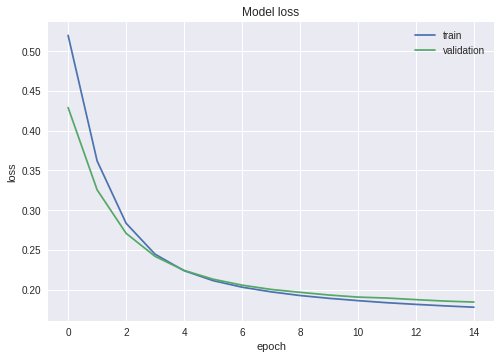

In [0]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### Treshold optimization
DISCLAIMER : Does not work as intended.

In that part we strive to optimize the treshold of activation of each label, in order to maximize F1 score

In [0]:
# Concatenating all the batches _label_ output in order to not compute it several 
# times for F1 score optimization.
import sklearn.metrics
def make_pred(bounded_output_all, tresholds):
  return bounded_output_all.data.gt(tresholds) # Activation

def compute_f1(tresholds_as_tensor):
  f1 = 0 # Will be the average f1 over all batches (according to their sizes)
  for i, (inputv, targetv) in enumerate(test_loader):
    inputv = inputv.to(device)
    targetv = targetv.to(device)
    
    batch_size = len(inputv)
    bounded_output = torch.sigmoid(model(inputv))
    
    pred = bounded_output.data.gt(tresholds_as_tensor)
    curr_f1 = sklearn.metrics.f1_score(targetv.cpu(), pred.cpu(), average="micro") # same result
    f1 += curr_f1 * (batch_size)
  return f1/len(test_dataset)

In [0]:
ounded_output = torch.sigmoid(model(inputv))

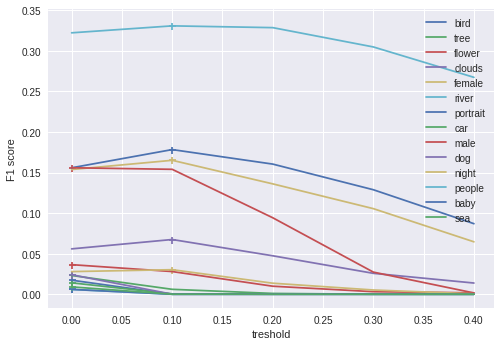

In [0]:
    plt.xlabel("treshold")
    plt.ylabel("F1 score")
    for label in range(0,14):
      plt.plot(tresholds , tab[label], label=oneHotTransformer.vocabulary[label])
      imax = np.argmax(tab[label])
      plt.scatter(tresholds[imax], tab[label][imax], marker="+")
    plt.legend()
    plt.show()

label 0
  t= 0.0 	 f1 = 0.01738558436554055


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  t= 0.044444444444444446 	 f1 = 0.0023332271109233692
  t= 0.08888888888888889 	 f1 = 0.0
  t= 0.13333333333333333 	 f1 = 0.0
  t= 0.17777777777777778 	 f1 = 0.0
  t= 0.22222222222222224 	 f1 = 0.0
  t= 0.26666666666666666 	 f1 = 0.0
  t= 0.3111111111111111 	 f1 = 0.0
  t= 0.35555555555555557 	 f1 = 0.0
  t= 0.4 	 f1 = 0.0
label 1
  t= 0.0 	 f1 = 0.022946867674901433
  t= 0.044444444444444446 	 f1 = 0.02106452738606191
  t= 0.08888888888888889 	 f1 = 0.009571118171103147
  t= 0.13333333333333333 	 f1 = 0.003446778711484594
  t= 0.17777777777777778 	 f1 = 0.0008045254556882464
  t= 0.22222222222222224 	 f1 = 0.00037209302325581393
  t= 0.26666666666666666 	 f1 = 0.0
  t= 0.3111111111111111 	 f1 = 0.0
  t= 0.35555555555555557 	 f1 = 0.0
  t= 0.4 	 f1 = 0.0
label 2
  t= 0.0 	 f1 = 0.03660035063359453
  t= 0.044444444444444446 	 f1 = 0.03882949077469934
  t= 0.08888888888888889 	 f1 = 0.029916956003431524
  t= 0.13333333333333333 	 f1 = 0.021351904801913242
  t= 0.17777777777777778 	 f1 =

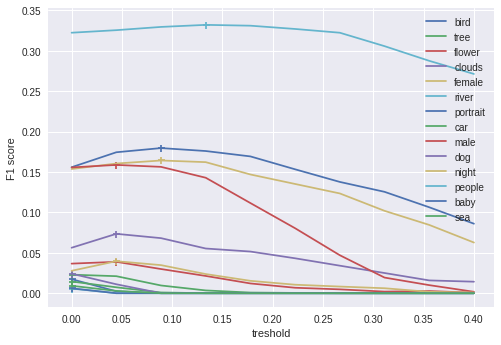

tresholds: [0.0, 0.0, 0.044444444444444446, 0.044444444444444446, 0.08888888888888889, 0.0, 0.08888888888888889, 0.0, 0.044444444444444446, 0.0, 0.044444444444444446, 0.13333333333333333, 0.0, 0.0]


In [0]:
# Optimizing treshold for each label : Iterating over labels
# Dropout layers have the effect of making a network not returning the same output for a same output at different runs
# This means that F1 score function will be "noisy", ie it won't be a smooth curve.
# This makes optimization much more complicate than simply a SGD descent. To be tolerant of that case, 
# we check all values in order to not be tricked by noise, and choose the observed maximum.

    
class tresholdOptimizer():
  def __init__(self, paces=10, max=1): # High pace means more precision but slower computation
    self.tresholds = np.linspace(0,max,paces)
    for i in range(14): # label
      current_tresholds = [1 for _ in range(14)] # 1 so other labels are never activated,
                                                 # and only the currently studied treshold make the f1 vary
      f1 = []
      print("label", i)
      for t in self.tresholds:
        current_tresholds[i] = t
        tresholds_as_tensor = torch.Tensor(current_tresholds).to(device) 
        f1_curr = compute_f1(tresholds_as_tensor)
        f1.append(f1_curr)
        #print("  t=", t, "\t f1 =", f1_curr)
      if i==0:
        self.tab = [f1]
      else:
        self.tab.append(f1)
        
  def view(self):
    plt.xlabel("treshold")
    plt.ylabel("F1 score")
    for label in range(0,14):
      plt.plot(self.tresholds , self.tab[label], label=oneHotTransformer.vocabulary[label])
      imax = np.argmax(self.tab[label])
      plt.scatter(self.tresholds[imax], self.tab[label][imax], marker="+")
    plt.legend()
    plt.show()

  def get_best_tresholds(self):
    res = []
    for label in range(0,14):
      imax=np.argmax(self.tab[label])
      res.append(self.tresholds[imax])
    return res

treshold_opt = tresholdOptimizer(max=0.4) 
treshold_opt.view()
print("tresholds:", treshold_opt.get_best_tresholds())

In [0]:
# CAREFUL! It appears that my implementation does not work. A constant treshold of 0.2
# appear to yield much better f1 than my implementation. Some fields are detected as performing best with 0, 
# with our optimizer which is wrong as shown below.

# tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!


tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!)      
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
f1 = compute_f1(tresholds_as_tensor)
#f1 = sklearn.metrics.f1_score(truth_all.cpu(), pred_all.cpu(), average="micro") # same result
print("tresholds", tresholds_as_tensor)
print("F1 score : {:.2f}%\n".format(f1*100))
      



tresholds tensor([0.0000, 0.0000, 0.0444, 0.0444, 0.0889, 0.0000, 0.0889, 0.0000, 0.0444,
        0.0000, 0.0444, 0.1333, 0.0000, 0.0000], device='cuda:0')
F1 score : 15.01%



### F1 score

In [0]:
import sklearn.metrics

def compute_f1_acc(tresholds_as_tensor):
  f1 = 0 # Will be the average f1 over all batches (according to their sizes)
  for i, (inputv, targetv) in enumerate(test_loader):
    inputv = inputv.to(device)
    targetv = targetv.to(device)
    
    batch_size = len(inputv)
    bounded_output = torch.sigmoid(model(inputv))
    
    pred = bounded_output.data.gt(tresholds_as_tensor)
    curr_f1 = sklearn.metrics.f1_score(targetv.cpu(), pred.cpu(), average="micro") # same result
    f1 += curr_f1 * (batch_size)
    return 
#tresholds = [0.2 for _ in range(14)]
tresholds = [0.2, 0.2,
             0.2, 0.2,
             0.2, 0.2,
             0.2, 0.2,
             0.2, 0.2,
             0.2, 0.2,
             0.2, 0.2
          ]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
f1 = compute_f1(tresholds_as_tensor)
print("tresholds", tresholds_as_tensor)
print("F1 score : {:.2f}%\n".format(f1*100))

tresholds tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000], device='cuda:0')
F1 score : 44.74%



In [0]:
#tresholds = [0.2 for _ in range(14)]
tresholds = [0.3, 0.2,
             0.2, 0.2,
             0.225, 0.25,
             0.2, 0.25,
             0.225, 0.35,
             0.2, 0.3,
             0.25, 0.2
          ]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
f1 = compute_f1(tresholds_as_tensor)
f1s = 0
for _ in range(5):
  f1s += compute_f1(tresholds_as_tensor)
f1s /= 5
print("tresholds", tresholds_as_tensor)
print("F1 avg score : {:.2f}%\n".format(f1s*100))

tresholds tensor([0.3000, 0.2000, 0.2000, 0.2000, 0.2250, 0.2500, 0.2000, 0.2500, 0.2250,
        0.3500, 0.2000, 0.3000, 0.2500, 0.2000], device='cuda:0')
F1 avg score : 46.78%



In [0]:
#tresholds = [0.2 for _ in range(14)]
tresholds = [0.3, 0.2,
             0.2, 0.2,
             0.225, 0.25,
             0.2, 0.25,
             0.225, 0.35,
             0.2, 0.3,
             0.25, 0.25
          ]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
f1 = compute_f1(tresholds_as_tensor)
f1s = 0
for _ in range(5):
  f1s += compute_f1(tresholds_as_tensor)
f1s /= 5
print("tresholds", tresholds_as_tensor)
print("F1 avg score : {:.2f}%\n".format(f1s*100))

tresholds tensor([0.3000, 0.2000, 0.2000, 0.2000, 0.2250, 0.2500, 0.2000, 0.2500, 0.2250,
        0.3500, 0.2000, 0.3000, 0.2500, 0.2500], device='cuda:0')
F1 avg score : 46.79%



In [0]:
# Deprecated cell!
# Result with """ Optimized """ tresholds
from sklearn.metrics import classification_report
tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!)      
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)

target_names = oneHotTransformer.vocabulary
#report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names, output_dict=True)
report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names)
print("with tresholds", list(zip(target_names, tresholds)))
print(report)
# Apparently, the optimization is good for all f1-score avg _EXCEPT_ micro (compare with the cell below)

with tresholds [('bird', 0.0), ('tree', 0.0), ('flower', 0.0), ('clouds', 0.0), ('female', 0.13793103448275862), ('river', 0.0), ('portrait', 0.13793103448275862), ('car', 0.0), ('male', 0.10344827586206896), ('dog', 0.0), ('night', 0.0), ('people', 0.0), ('baby', 0.0), ('sea', 0.0)]
              precision    recall  f1-score   support

        bird       0.01      1.00      0.01         2
        tree       0.02      1.00      0.04         6
      flower       0.00      1.00      0.01         1
      clouds       0.03      1.00      0.05         8
      female       0.37      0.95      0.53        92
       river       0.00      1.00      0.01         1
    portrait       0.33      0.93      0.49        74
         car       0.01      1.00      0.01         2
        male       0.21      1.00      0.35        59
         dog       0.02      1.00      0.03         5
       night       0.02      1.00      0.05         7
      people       0.56      1.00      0.72       159
        baby

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [0]:
# Deprecated cell!
# Result with rubbish tresholds
from sklearn.metrics import classification_report
tresholds = [0.2 for _ in range(14)]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)

target_names = oneHotTransformer.vocabulary
#report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names, output_dict=True)
report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names)
print("with tresholds", list(zip(target_names, tresholds)))
print(report)

with tresholds [('bird', 0.2), ('tree', 0.2), ('flower', 0.2), ('clouds', 0.2), ('female', 0.2), ('river', 0.2), ('portrait', 0.2), ('car', 0.2), ('male', 0.2), ('dog', 0.2), ('night', 0.2), ('people', 0.2), ('baby', 0.2), ('sea', 0.2)]
              precision    recall  f1-score   support

        bird       0.00      0.00      0.00         2
        tree       0.00      0.00      0.00         6
      flower       0.00      0.00      0.00         1
      clouds       0.00      0.00      0.00         8
      female       0.41      0.74      0.53        92
       river       0.00      0.00      0.00         1
    portrait       0.37      0.77      0.50        74
         car       0.00      0.00      0.00         2
        male       0.21      0.64      0.31        59
         dog       0.00      0.00      0.00         5
       night       0.00      0.00      0.00         7
      people       0.56      0.99      0.71       159
        baby       0.00      0.00      0.00         2
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [0]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    tresholds = [0.3, 0.2,
             0.2, 0.2,
             0.225, 0.25,
             0.2, 0.25,
             0.225, 0.35,
             0.2, 0.3,
             0.25, 0.25
          ]
    tresholds_as_tensor = torch.Tensor(tresholds).to(device) 
    pred = output.data.gt(tresholds_as_tensor) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
Truth
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [26]:
to_test_path = 'to_test'
dl_file = 'dl2018-image-test.zip'
dl_url = 'https://users.aalto.fi/~mvsjober/misc/'

zip_path = os.path.join(to_test_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=to_test_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(to_test_path)

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
order = ['baby', # given order, most likely different from the order constructed
 'bird',         # automatically in the preprocessing part.
 'car',
 'clouds',
 'dog',
 'female',
 'flower',
 'male',
 'night',
 'people',
 'portrait',
 'river',
 'sea',
 'tree']
# Permutation table (arrays' indices to permute) 
switch = [0 for _ in range(14)]
for i in range(14):
  searched =  order[i]
  switch[i] = oneHotTransformer.vocabulary.index(searched)

def batch_output_in_right_order(batch_pred, order_switch):
  return batch_pred[:, order_switch]
  

# Example for one batch
inputv, targetv = next(test_loader.__iter__())
inputv = inputv.to(device)
best_tresholds_as_tensor = torch.Tensor([0.2]*14).to(device)
batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor

batch_right_order = batch_output_in_right_order(batch_pred, switch)


Truth:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])
Labelled Truth:  ['female', 'portrait', 'people']
----------
new order ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
re ordered tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])


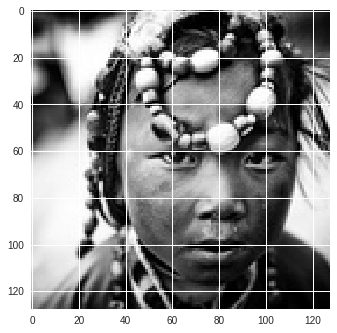

In [0]:
# Double check it works
print("Truth: ", targetv[0])
print("Labelled Truth: ", oneHotTransformer.toVocabulary(targetv[0]))

ex0 = batch_right_order[0]


print("-"*10)
print("new order", order)
#print(inputv.cpu().numpy()[0][0])


targetv_good_order = batch_output_in_right_order(targetv, switch)
t0 = targetv_good_order[0]
plt.imshow(inputv.cpu().numpy()[0][0], cmap="gray")
#print(batch_output_in_right_order(batch_pred, switch))
print("re ordered", t0)
plt.show()



In [0]:
images_path_test = "to_test/images/" 
image_files_test = [(images_path_test+f) for f in os.listdir(images_path_test) \
                if os.path.isfile(os.path.join(images_path_test, f))]

image_files_test = sorted(image_files_test)
def to_basename(rel_path):
  """ 'to_test/images/im20001.jpg' to '20001' """
  return rel_path[17:-4] # stripping 17 first chars and last 4 ones (extension of the file)
basenames_test = [to_basename(path) for path in image_files_test] 

to_test_dataset = imageDataset(basenames_test, merging_method = merge_method, train=False)
to_test_loader = torch.utils.data.DataLoader(dataset=to_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [34]:
# Training the model again on _all_ of the data
train_dataset = build_augmented_dataset(images)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
model = deep_cnn(input_channels=3).to(device)


# These parameters are the ideal ones according to the studied done before
# with the validation dataset (see previous plot)
learning_rate = 0.0001 # for deep_cnn
epoch = 15
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
train_loss = []
for i in range(1,1+epoch):
    train_net(model, i, train_loss)

KeyboardInterrupt: ignored

In [0]:
# Concatenate all predictions
tresholds = [0.3, 0.2,
             0.2, 0.2,
             0.225, 0.25,
             0.2, 0.25,
             0.225, 0.35,
             0.2, 0.3,
             0.25, 0.25
          ] # Optimized treshold
for i, (inputv, targetv) in enumerate(to_test_loader):
  inputv = inputv.to(device)
  best_tresholds_as_tensor = torch.Tensor(tresholds).to(device)
  batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor
  
  batch_right_order = batch_output_in_right_order(batch_pred, switch)
  print(i+1, "/", len(to_test_loader))
  if i==0:
    y = batch_right_order
  else:
    y = torch.cat((y, batch_right_order), 0) # Adding new batch to the list of predictions

0 / 125
1 / 125
2 / 125
3 / 125
4 / 125
5 / 125
6 / 125
7 / 125
8 / 125
9 / 125
10 / 125
11 / 125
12 / 125
13 / 125
14 / 125
15 / 125
16 / 125
17 / 125
18 / 125
19 / 125
20 / 125
21 / 125
22 / 125
23 / 125
24 / 125
25 / 125
26 / 125
27 / 125
28 / 125
29 / 125
30 / 125
31 / 125
32 / 125
33 / 125
34 / 125
35 / 125
36 / 125
37 / 125
38 / 125
39 / 125
40 / 125
41 / 125
42 / 125
43 / 125
44 / 125
45 / 125
46 / 125
47 / 125
48 / 125
49 / 125
50 / 125
51 / 125
52 / 125
53 / 125
54 / 125
55 / 125
56 / 125
57 / 125
58 / 125
59 / 125
60 / 125
61 / 125
62 / 125
63 / 125
64 / 125
65 / 125
66 / 125
67 / 125
68 / 125
69 / 125
70 / 125
71 / 125
72 / 125
73 / 125
74 / 125
75 / 125
76 / 125
77 / 125
78 / 125
79 / 125
80 / 125
81 / 125
82 / 125
83 / 125
84 / 125
85 / 125
86 / 125
87 / 125
88 / 125
89 / 125
90 / 125
91 / 125
92 / 125
93 / 125
94 / 125
95 / 125
96 / 125
97 / 125
98 / 125
99 / 125
100 / 125
101 / 125
102 / 125
103 / 125
104 / 125
105 / 125
106 / 125
107 / 125
108 / 125
109 / 125
110 / 125


In [0]:
np.savetxt('results.txt', y.cpu(), fmt='%d')